# Classification of earthquakes signals using variational autoencoder

Dataset: http://www.timeseriesclassification.com/description.php?Dataset=Earthquakes

We adopt them to classify the negative and positive cases using the method of variational autoencoder, where the data is imbalanced. 

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, jaccard_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

Load the data

In [2]:
train = arff.loadarff('Earthquakes_TRAIN.arff')
test = arff.loadarff('Earthquakes_TEST.arff')

In [3]:
train = pd.DataFrame(train[0])
test = pd.DataFrame(test[0])

In [4]:
train['target'].value_counts()

b'0'    264
b'1'     58
Name: target, dtype: int64

In [5]:
positive_train = train[train.target==b'1']
negative_train = train[train.target==b'0']
positive_test = test[test.target==b'1']
negative_test = test[test.target==b'0']

In [6]:
negative_train_X = negative_train.iloc[:,:-1].values
negative_test_X = negative_test.iloc[:,:-1].values
positive_train_X = positive_train.iloc[:,:-1].values
positive_test_X = positive_test.iloc[:,:-1].values

In [7]:
test_X = test.iloc[:,:-1].values

Label the data 

In [8]:
le = LabelEncoder()
train_y =le.fit_transform(train.iloc[:,-1])
test_y =le.transform(test.iloc[:,-1])

In [9]:
values, counts = np.unique(train_y, return_counts=True)
print("Labels: ", dict(zip(values, counts)))

Labels:  {0: 264, 1: 58}


Label 0 as negative and 1 as positive

In [10]:
#Model Parameters
input_dim = positive_train_X.shape[1]
input_shape = (input_dim,)
hidden_dim = int(input_dim / 2)
latent_dim = int(input_dim / 4)
num_hidden = 2

batch = 128
epochs = 800

learning_rate = 1e-4
activation = 'relu'

# Variational AutoEncoder

In [11]:
class VariationalAutoEncoder(object):
    '''
       Anomaly detection using variational autoencoder
    
    '''
    def __init__(self, *args):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.activation = activation
        self.model = self.model()
        
    def sample(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = z_mean.get_shape()[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def vae_loss(self, x, x_decoded_mean):
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        kl_loss = - 0.5 * tf.reduce_sum(1 + self.z_log_var - tf.square(self.z_mean) 
                                        - tf.square(tf.exp(self.z_log_var)), axis=-1)
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        return total_loss
    
    def model(self):
        # encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(self.input_dim, activation=self.activation)(inputs)
        for i in range(self.num_hidden):
            x = Dense(self.hidden_dim, activation=self.activation)(x)
        self.z_mean = Dense(self.latent_dim, name='z_mean')(x)
        self.z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        z = Lambda(self.sample, output_shape=(self.latent_dim,), name='z')([self.z_mean, 
                                                                            self.z_log_var])
        encoder = Model(inputs, z, name='encoder')
        
        # decoder model
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(self.hidden_dim, activation=self.activation)(latent_inputs)
        if self.num_hidden > 1:
            for i in range(self.num_hidden-1):
                x = Dense(self.hidden_dim, activation=self.activation)(x)
        outputs = Dense(self.input_dim, activation='sigmoid')(x)
        decoder = Model(latent_inputs, outputs, name='decoder')

        outputs = decoder(encoder(inputs))
        vae_model = Model(inputs, outputs, name='vae_model')
       
        vae_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate), 
                          loss=self.vae_loss)
        return vae_model

In [12]:
vae = VariationalAutoEncoder(input_dim, hidden_dim, latent_dim, num_hidden, learning_rate)

In [13]:
vae.model.summary()

Model: "vae_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 512)]             0         
_________________________________________________________________
encoder (Functional)         (None, 128)               525568    
_________________________________________________________________
decoder (Functional)         (None, 512)               230400    
Total params: 755,968
Trainable params: 755,968
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = vae.model.fit(positive_train_X, positive_train_X,
                        shuffle=True,
                        epochs=epochs,
                        batch_size=batch,
                        verbose=0)

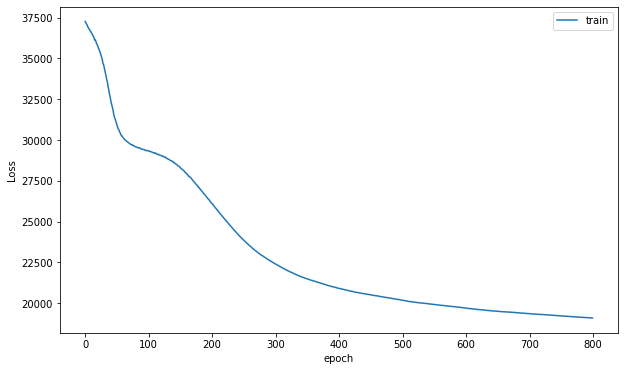

In [15]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

In [16]:
def reconstruct_err(model, data):
    reconstructions = model.predict(data)
    err = mean_absolute_error(data.T, reconstructions.T, multioutput='raw_values')
    return err

In [17]:
positive_err = reconstruct_err(vae.model, positive_train_X)
negative_err = reconstruct_err(vae.model, negative_train_X)

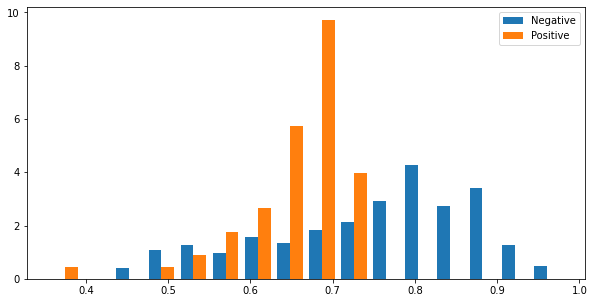

In [18]:
bins = int(np.sqrt(negative_err.shape[0]))
plt.figure(figsize=(10,5))
plt.hist([negative_err, positive_err], bins, label=['Negative', 'Positive'], density=True)
plt.legend()
plt.show()

In [19]:
threshold = np.quantile(positive_err, 0.99) 

In [20]:
err = reconstruct_err(vae.model, test_X)
prediction = (err > threshold)
prediction = [int(x) for x in prediction]

In [21]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    acc = accuracy_score(truedata, pred)
    f1 = f1_score(truedata, pred)
    jaccard = jaccard_score(truedata, pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    gmean = np.sqrt(sensitivity*specificity)
    print("Accuracy: ", round(acc,3))
    print("F1 score: ", round(f1,3))
    print("Jaccard Score: ", round(jaccard,3))
    print("G-Mean: ", round(gmean,3))
    return [acc, f1, jaccard, gmean]

# Summary

In [22]:
column = ['Accuracy', 'F1 Score', 'Jaccard Score', 'G-Mean']
metrics = pd.DataFrame(columns=column)

temp = pd.DataFrame(classification_metrics(test_y, prediction)).T

Metrics
True positive:  33
True negative:  35
False positive:  69
False negative:  2

Accuracy:  0.489
F1 score:  0.482
Jaccard Score:  0.317
G-Mean:  0.563


# References:

<li>
https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5
<li>
https://www.kdnuggets.com/2018/11/variational-autoencoders-explained.html
<li>
https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf